# Install Dependencies

## Download Needed Libraries

In [ ]:
!pip install -q huggingface-hub
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 

## Clone `diffusers` and Install it

In [ ]:
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!pip install -q .

Cloning into 'diffusers'...
remote: Enumerating objects: 88432, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 88432 (delta 358), reused 226 (delta 219), pack-reused 87961 (from 4)
Receiving objects: 100% (88432/88432), 64.20 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (64971/64971), done.
/kaggle/working/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Install `requirements` in `diffusers/examples/text_to_image`

In [ ]:
%cd ..
!pip install -q -r diffusers/examples/text_to_image/requirements.txt

/kaggle/working
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


## Download an Convert Dataset

In [ ]:
import pandas as pd
import os
from PIL import Image
import io
import shutil
import json
from huggingface_hub import snapshot_download

# Download the dataset to the specified local directory
snapshot_download(
    repo_id="uwunish/ghibli-dataset",
    repo_type="dataset",
    local_dir="dataset",
    local_dir_use_symlinks=False
)

# Define paths
dataset_root = "dataset"
parquet_path = os.path.join(dataset_root, "data/train-00000-of-00001.parquet")
output_dir = dataset_root

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Read the Parquet file
df = pd.read_parquet(parquet_path)

# Check the columns in the Parquet file
print("Columns in Parquet file:", df.columns)

# Assume columns are 'image' (bytes) and 'text' (caption)
# Adjust column names if different (e.g., 'caption' instead of 'text')
image_column = "image"  # Column containing image bytes
text_column = "text"    # Column containing captions

# Verify that the expected columns exist
if image_column not in df.columns or text_column not in df.columns:
    raise ValueError(f"Expected columns '{image_column}' and '{text_column}' not found in Parquet file. Available columns: {df.columns}")

# Open metadata.jsonl for writing
metadata_path = os.path.join(output_dir, "metadata.jsonl")
with open(metadata_path, "w") as f:
    # Process each row in the Parquet file
    for idx, row in df.iterrows():
        # Extract image bytes and caption
        image_bytes = row[image_column]['bytes'] # Access the 'bytes' key to get the actual bytes
        caption = row[text_column]

        # Convert image bytes to an image and save it
        image = Image.open(io.BytesIO(image_bytes))
        image_filename = f"image_{idx:05d}.png"  # e.g., image_00000.png
        image_path = os.path.join(output_dir, image_filename)
        image.save(image_path, format="PNG")

        # Write metadata entry
        metadata_entry = {"file_name": image_filename, "text": caption}
        f.write(json.dumps(metadata_entry) + "\n")

# Clean up: Remove the 'dataset' folder and any other unnecessary files
shutil.rmtree(os.path.join(dataset_root, "data"))
readme_path = os.path.join(dataset_root, "README.md")
if os.path.exists(readme_path):
    os.remove(readme_path)

# Configure `accelerate`

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


# Import Libraries

In [ ]:
import huggingface_hub
import accelerate
import bitsandbytes

import torch
import PIL, transformers, diffusers
from PIL  import Image
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler

# Training

## Using a Local Converted Dataset

In [ ]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base" \
  --train_data_dir="./dataset" \
  --use_ema \
  --use_8bit_adam \
  --mixed_precision="fp16" \
  --resolution=64 --center_crop \
  --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --num_train_epochs=40 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="ghibli-fine-tuned-sd-2.1" \
  --checkpoints_total_limit=1 \
  --caption_column="text"

## Using a Hugging Face Dataset

In [ ]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base" \
  --dataset_name="uwunish/ghibli-dataset" \
  --use_ema \
  --use_8bit_adam \
  --mixed_precision="fp16" \
  --resolution=512 --center_crop \
  --random_flip \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --num_train_epochs=40 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="ghibli-fine-tuned-sd-2.1" \
  --checkpoints_total_limit=1 \
  --caption_column="text"

2025-04-18 08:46:38.428942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744965998.451775     160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744965998.458527     160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
scheduler_config.json: 100%|███████████████████| 346/346 [00:00<00:00, 2.52MB/s]
{'timestep_spacing', 'thresholding', 'variance_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'sample_max_value', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
tokenizer_config.json: 100%|███████████████████| 807/807 [00:00<00:00, 5.44MB/s]
vocab.json: 100%|██████████████████████████| 1.06M/1.

# Inference

In [ ]:
import torch
from PIL import Image
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler
from tqdm import tqdm

In [ ]:
# Set device and dtype
if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float16  # Use float16 for CUDA
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    dtype = torch.float32  # Use float32 for MPS
else:
    device = torch.device("cpu")
    dtype = torch.float32  # Use float32 for CPU

# Model path
model_name = "ghibli-fine-tuned-sd-2.1"

# Load models with consistent dtype
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", torch_dtype=dtype).to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", torch_dtype=dtype).to(device)

# Load scheduler
scheduler = PNDMScheduler.from_pretrained(model_name, subfolder="scheduler")

# Configurable parameters
prompt = ["donald trump in ghibli style"]
height = 512  # Configurable height (must be divisible by 8)
width = 512   # Configurable width (must be divisible by 8)
num_inference_steps = 50
guidance_scale = 3.5
batch_size = 1
seed = 42

# Validate height and width
if height % 8 != 0 or width % 8 != 0:
    raise ValueError("Height and width must be divisible by 8 for Stable Diffusion.")

# Create device-specific generator
generator = torch.Generator(device=device).manual_seed(seed)

# Tokenize and encode prompt
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0].to(dtype=dtype)

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0].to(dtype=dtype)

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Initialize latents with configurable height and width
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),  # Use unet.config.in_channels
    generator=generator,
    dtype=dtype,
    device=device
)

# Set scheduler timesteps
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

# Inference loop
for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        if device.type == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        else:
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Decode latents to image
with torch.no_grad():
    latents = latents / vae.config.scaling_factor
    image = vae.decode(latents).sample



100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


In [ ]:
# Convert image to PIL for saving/viewing
image = (image / 2 + 0.5).clamp(0, 1)  # Clamp as a PyTorch tensor
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()  # Convert to NumPy
image = (image * 255).round().astype("uint8")  # Scale and convert to uint8
pil_image = Image.fromarray(image[0])  # Convert to PIL Image
pil_image.save("ghibli_style_girl.png")

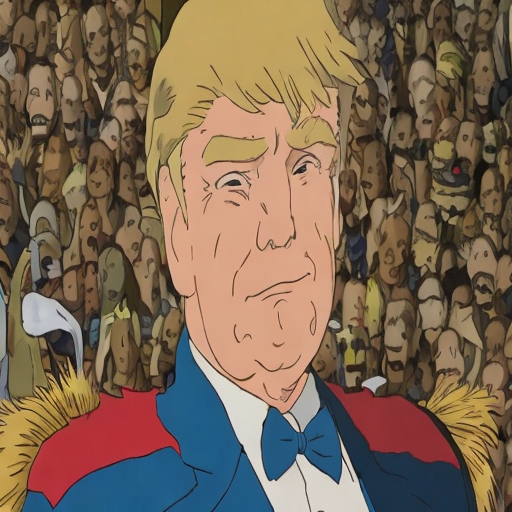

In [ ]:
pil_image